WELCOME!

This Code is used to test Memory Lab's ability to recover the alpha parameter. In this file, we use Marteen van der Velde's spacing model and my ACT-R memory model to see how well memory lab does at recovering sof.

In [49]:
from slimstampen.spacingmodel import SpacingModel, Fact, Response
import matplotlib.pyplot as plt 
from numpy import pi, sqrt, exp, log, e, Infinity
import numpy as np
import random as r
from memory import memory
from scipy.stats import logistic
from matplotlib.ticker import PercentFormatter
import pandas 

These are Methods that the model uses to simulate response accuracy and time

In [50]:
#Need to create a timeline for each memory lab to go for
    #How long should each one be?
    #First need to set up response time determination and correct response determination


#Returns a random activation based off of the determinstic eq and the logistic distribution of activation.
# m: Memory to calculate random activation of
# t: time in which activation will be measured
def noise_actv(m, t):
    sd = pi * m.get_s()/ sqrt(3)
    noisedist = logistic(m.get_actv(t), sd)
    new_actv = noisedist.rvs()
    return new_actv

#Returns aresponse time based off of the deterministic eq for response time and activation
#actv: Activation of memory
#t0: Reaction time buffer, basically the minimum resposnse time
def calc_rst(actv, t0):
    return t0 + (e ** (- actv))


#Returns a true or false response based off the activation, the s parameter, and our determined activation threshold (What is the actv thresh?)
def get_response(actv, s, thresh):
    prob = 1 / (1 + e ** (-(actv - thresh) / s))
    resp = r.uniform(0, 1) <= prob
    return resp



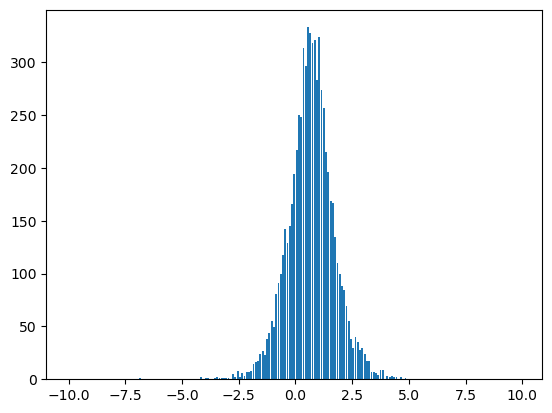

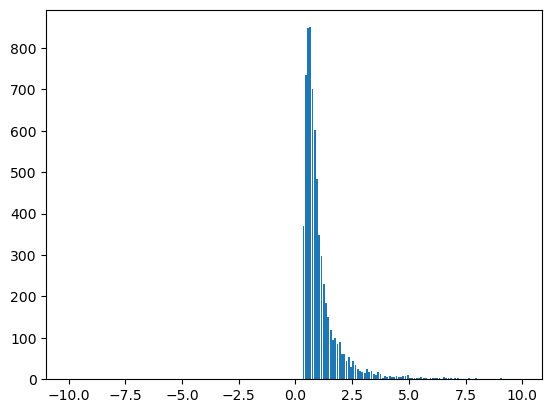

0.5941717023108526
0.7501544760006513
0.4946116637734482
0.48606626488340793
0.5116444495426677
0.7804108188664247
0.6531672119243059
0.5518307837807126
0.6383567053927598
5.490063435822718


In [51]:
#Testing out Methods do not worry about this block

m = memory(0.3, 0.25, 0.3)
m.add_trace(0)
t = []

for _ in range(7000):
    t.append(noise_actv(m, 0.1))

a = plt.hist(t, [x / 10 for x in range(-100, 100)], rwidth=0.8)
plt.show()


t = [calc_rst(x, t0=0.3) for x in t]

a = plt.hist(t, [x / 10 for x in range(-100, 100)], rwidth=0.8)
plt.show()

for x in range(10):
    print(t[x])

In [52]:
#Next, need to create facts that can be tested against, and have teh thing predict my alpha/sof
#please remember the 600 ms buffer as well as the reaction time buffer. so, every new question should increase time by 600ms at start
# not even considering reaction time

#could just start with time 0 at every
SIM_END_TIME = 1 #minutes
FORGET_THRESHOLD = -0.8
NUM_FACTS = 20
sof = 0.3
SPC = 0.25
S = 0.3
F = 1 
t0 = 0.3

q_buff = 0.6


In [53]:
#remember that model for get_next_fact returns true if fact is new and hasnt been presented

#also need to remember to add memory traces whenever a new fact is presented, and the 4000 milli dif of incorrect answer,
#600 ms block spacing otherwise

#DEBUG 7/3/24: Bro so I just realized rst was in milliseconds for spacing model, but I am using and passing seconds. So
#I have been passing 1/1000 of what I should of been for response time. This change was noticed as activation was wayyy
#too high. Going to try and fix by multiplying my values by 1000 (time and resp time)

"Taking in an SOF, simulates model with that sof in a memory lab test, and returns the estimated sof for each fact"
def simulate(SOF):
    t = 0
    sm = SpacingModel()

    memories = []

    for x in range(NUM_FACTS):
        fact = Fact(x, "q", "q")
        sm.add_fact(fact)
        memories.append(memory(SOF, SPC, s=S, F=F))

    while t <= SIM_END_TIME * 60:
        fact, new = sm.get_next_fact(t * 1000)

        if new:
            #IF FACT IS NEW, ADD CREATE FACT MEMORY, PLEASE ASK ANDREA ABOUT THIS
            #Okay so the way its currently set up, I get -infinity when t = encoding time, but should be infinity at that time no?
            #Im gonna do it ask andrea abti it l8r
            
            fact_id = fact.fact_id
            memories[fact_id].add_trace(t)
            actv = Infinity                         #PLEASSE COME BACK TO THIS
            corr = get_response(actv, S, FORGET_THRESHOLD)
            rst = calc_rst(actv, t0) # for milliseconds

            t += rst

            resp = Response(fact, t * 1000, rst * 1000, corr)
            sm.register_response(resp)

            t += q_buff

        else:
            fact_id = fact[0]
            actv = noise_actv(memories[fact_id], t)
            corr = get_response(actv, S, FORGET_THRESHOLD)
            rst = calc_rst(actv, t0)

            resp = Response(fact, t * 1000, rst * 1000, corr)
            sm.register_response(resp)

            t += rst
            memories[fact_id].add_trace(t)
            
            if corr:
                t += q_buff
            else:
                t += 4
    
    sof = []
    for x in range(NUM_FACTS):
        sof.append(sm.get_rate_of_forgetting(t * 1000, sm.facts[x]))

    return sof

In [60]:
#Darker is older, lighter is newer
#INDV Participant
num_part = 2
msofs = [x / 100 for x in range(20, 50)]
sofs = []

for msof in msofs:
    for _ in range(num_part):
        simsofs = simulate(msof)
        simsofs.insert(0, msof)
        sofs.append(simsofs)
        
cols = [f'Q{x}' for x in range (1, 21)]
cols.insert(0, "ModelSOF")

print(len(sofs))
print((cols))
df = pandas.DataFrame(np.array(sofs), columns=cols)
pandas.concat([pandas.DataFrame({"s":S, "F" : F, "spc" : SPC, "t0" : t0, "#facts": NUM_FACTS, "simtime" : SIM_END_TIME}, index=["settings"]), df])
print(df)
df.to_csv(f"s({S})F({F})spc({SPC})t0({t0})#f({NUM_FACTS})simt({SIM_END_TIME})forgetThresh({FORGET_THRESHOLD})")

60
['ModelSOF', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20']


TypeError: concat() takes 1 positional argument but 2 were given

0.2
0
1
2
3
4
5
6
7
8
9
0.21
0
1
2
3
4
5
6
7
8
9
0.22
0
1
2
3
4
5
6
7
8
9
0.23
0
1
2
3
4
5
6
7
8
9
0.24
0
1
2
3
4
5
6
7
8
9
0.25
0
1
2
3
4
5
6
7
8
9
0.26
0
1
2
3
4
5
6
7
8
9
0.27
0
1
2
3
4
5
6
7
8
9
0.28
0
1
2
3
4
5
6
7
8
9
0.29
0
1
2
3
4
5
6
7
8
9
0.3
0
1
2
3
4
5
6
7
8
9
0.31
0
1
2
3
4
5
6
7
8
9
0.32
0
1
2
3
4
5
6
7
8
9
0.33
0
1
2
3
4
5
6
7
8
9
0.34
0
1
2
3
4
5
6
7
8
9
0.35
0
1
2
3
4
5
6
7
8
9
0.36
0
1
2
3
4
5
6
7
8
9
0.37
0
1
2
3
4
5
6
7
8
9
0.38
0
1
2
3
4
5
6
7
8
9
0.39
0
1
2
3
4
5
6
7
8
9
0.4
0
1
2
3
4
5
6
7
8
9
0.41
0
1
2
3
4
5
6
7
8
9
0.42
0
1
2
3
4
5
6
7
8
9
0.43
0
1
2
3
4
5
6
7
8
9
0.44
0
1
2
3
4
5
6
7
8
9
0.45
0
1
2
3
4
5
6
7
8
9
0.46
0
1
2
3
4
5
6
7
8
9
0.47
0
1
2
3
4
5
6
7
8
9
0.48
0
1
2
3
4
5
6
7
8
9
0.49
0
1
2
3
4
5
6
7
8
9
8


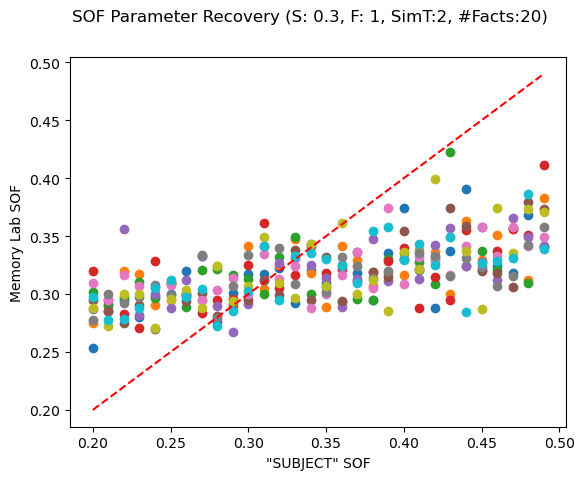

In [ ]:
#Darker is older, lighter is newer
#INDV Participant
num_part = 10
msofs = [x / 100 for x in range(20, 50)]
sofs = []



for msof in msofs:
    print(msof)
    for _ in range(num_part):
        print(_)
        sofs = simulate(msof)
        sofs = [i for i in sofs if i != 0.3] #CHANGE THIS WHENEVER BASLINE SOF CHANGES
        avg = sum(sofs)/len(sofs)
        plt.scatter(msof, avg)

print(len(sofs))
plt.suptitle(f"SOF Parameter Recovery (S: {S}, F: {F}, SimT:{SIM_END_TIME}, #Facts:{NUM_FACTS})")
plt.xlabel("\"SUBJECT\" SOF")
plt.ylabel("Memory Lab SOF")
plt.plot(msofs, msofs,"r--")
 
plt.show()

0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35
0.36
0.37
0.38
0.39
0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
20


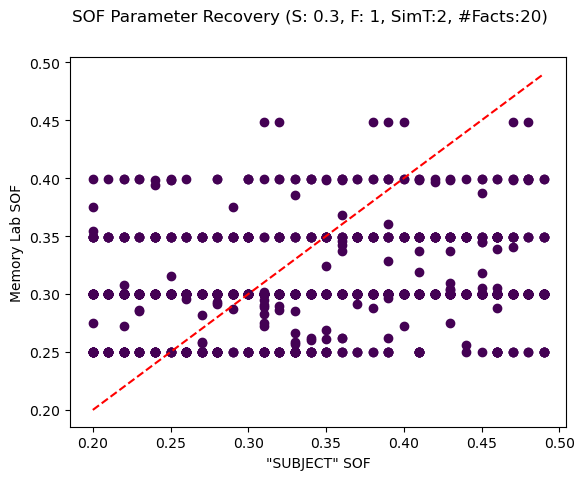

In [ ]:
#Facts
msofs = [x / 100 for x in range(20, 50)]
sofs = []
num_part = 2
mappy = {}


for msof in msofs:
    print(msof)
    for _ in range(num_part):
        sofs = simulate(msof)
        sofs = [i for i in sofs if i != 0.4]
        for sof in sofs:
            plt.scatter(msof, sof, c=((sofs.index(sof)+1)/len(sofs)))

print(len(sofs))
plt.suptitle(f"SOF Parameter Recovery (S: {S}, F: {F}, SimT:{SIM_END_TIME}, #Facts:{NUM_FACTS})")
plt.xlabel("\"SUBJECT\" SOF")
plt.ylabel("Memory Lab SOF")
plt.plot(msofs, msofs,"r--")
 
plt.show()